Visualisieren:
../../libMultiRobotPlanning-master/example/visualize.py test.yaml output.yaml


Basic Info:
[North, East, South, West]
DO_NOTHING= 0 MOVE_FORWARD= 2 MOVE_LEFT= 1 MOVE_RIGHT= 3 STOP_MOVING= 4

In [2]:
import sys
import time
from typing import Optional, List, Dict

import numpy as np

from flatland.core.env import Environment
from flatland.core.env_observation_builder import ObservationBuilder
from flatland.core.grid.grid_utils import coordinate_to_position
from flatland.envs.predictions import ShortestPathPredictorForRailEnv
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_generators import sparse_rail_generator
from flatland.envs.rail_generators import complex_rail_generator
from flatland.envs.schedule_generators import complex_schedule_generator
from flatland.envs.schedule_generators import sparse_schedule_generator
from flatland.utils.rendertools import RenderTool
from flatland.core.grid.grid4_utils import get_new_position


np.random.seed(100)

direction_to_str = {-1 : "pass...", 0: "North", 1: "East", 2: "South", 3: "West"}
action_to_str = {-1 : "pass...", 0 : "Do nothing", 1: "Left", 2 : "Forward", 3 : "Right", 4 : "Stop moving"}

In [34]:
# 20, 30, 3
# 25, 25, 5

render = True
print_more_info = False

try:

    # Initalize the Environment
    rail_generator=sparse_rail_generator(
        max_num_cities = 5,
        grid_mode= False,
        max_rails_between_cities = 5,
        max_rails_in_city = 5, 
        seed=0
    )
    
    env = RailEnv(
        width=50, height=50,
        rail_generator=rail_generator,
        schedule_generator=sparse_schedule_generator(),
        number_of_agents=17
    )
    
    obs, info = env.reset()
    
    
    # Just do one dummy step so the Trains get a Position. My assumtion is, that it is always the same
    env.step({i : 2 for i in range(env.get_num_agents())})
    
    # Check if the result of the prioritized planning is valied
    res = pp(env)
    if res == -1: raise Stop

    # For rendering the Environment and the steps done by the agents
    if render: 
        env_renderer = RenderTool(env, screen_width=2000, screen_height=2000)
        env_renderer.render_env(show=True, frames=False, show_observations=False, show_predictions=False)
    
    # Empty action dictionary which has the predicted actions in it for each step
    action_dict = dict()
    
    # For Loop with all the steps predicted by the agent
    for step in range(200):
        
        for handle in range(env.get_num_agents()):
        
            actions = res[handle]
            
            if not actions.is_empty() and info['action_required'][handle]:
                action, pred_positon = actions.pop(0)
                action_dict[handle] = action
                
                env.dev_pred_dict[handle] = actions.positions
            else:
                action_dict[handle] = 0
        
        # Do the actual step in the Enviroment based on the action_dict computed previously 
        obs, all_rewards, done, info = env.step(action_dict)
        
        # Print the current status of the agents in each iteration
        print(f"[{step+1:3}] In goal: {[handle for handle, status in done.items() if status]}")
        
        if print_more_info:
            print("Iteration:", step)
            for handle, action in action_dict.items():
                print(f"<{handle}> Action: |{action}|, Position: {env.agents[handle].position}, Target: {env.agents[handle].target}, Direction: {direction_to_str[env.agents[handle].direction]}")

        if render: 
            env_renderer.render_env(show=True, frames=False, show_observations=False, show_predictions=True)
            time.sleep(0.1)

        if done["__all__"]:
            print(f"\nAll Agents are in their targets! After {step+1} iterations.")
            break
            
finally:
    if render : env_renderer.close_window()


Checking if the starting positions are valid...
The positions for the 0 Step is not valid. Try one more step...
The positions for the 1 Step is not valid. Try one more step...
The positions are valid! Start searching...

Agent:  0 starting from: (34, 25) - heading to: (11, 40) --> in 0.109371sec
Agent:  1 starting from: (10, 38) - heading to: (36, 38) --> in 0.001429sec
Agent:  2 starting from: (30, 23) - heading to: (34, 38) --> in 0.003600sec
Agent:  3 starting from: (12, 38) - heading to: (32, 24) --> in 0.001050sec
Agent:  4 starting from: (19, 25) - heading to: (32, 24) --> in 0.001264sec
Agent:  5 starting from: (22, 12) - heading to: (32, 24) --> in 0.001064sec
Agent:  6 starting from: (10, 41) - heading to: (17, 26) --> in 0.002738sec
Agent:  7 starting from: (16, 25) - heading to: (13, 40) --> in 0.006737sec
Agent:  8 starting from: (33, 40) - heading to: (25, 10) --> in 0.001979sec
Agent:  9 starting from: (19, 23) - heading to: (36, 38) --> in 0.002201sec
Agent: 10 starting 

In [29]:
class NextCell():
    
    def __init__(self, position, action, cost, direction):
        self.position = position
        self.action = action
        self.cost = cost
        self.direction = direction

    def __repr__(self):
        return f"{self.position} | {action_to_str[self.action]} | {self.cost} | {direction_to_str[self.direction]}"


# Position, action, cost, direction
def calc_next_cell(position, direction, handle):            
    """
    for i in range(4):
        print(direction_to_str[i], i)
        print(calc_next_cell((33, 46), i, 6))
        print("-" * 50 + "\n")
    """
    
    possible_transitions = env.rail.get_transitions(*position, direction)

    # This should be never true when searching with the a star algorithm
    if all(d == 0 for d in possible_transitions):
        print("This Direction is not permissable!")
        return -1
    
    # Initalize the next_cells with the action when there is done nothing/waiting (4), because this is alway possible
    next_cells = [NextCell(position, 4, env.distance_map.get()[handle, position[0], position[1], direction], direction)]

    # Loop trough all the possible dirrections the agent can reach from current direction
    for d in [(direction + i) % 4 for i in range(-1, 2)]:
        
        if possible_transitions[d]:
            
            # Die neue Position, wenn man die jeweilige direction 
            new_position = get_new_position(position, d)
            
            
            # Die Distanz von einer Position zum Ziel des jeweiligen Agenten
            dist = env.distance_map.get()[handle, new_position[0], new_position[1], d]
            
            # Check the given directions and map it to the corresponding action
            if d == direction:
                next_cells.append(NextCell(new_position, 2, dist, d))

            elif (d + 1) % 4 == direction:
                next_cells.append(NextCell(new_position, 1, dist, d))
                
            elif (d - 1) % 4 == direction:
                next_cells.append(NextCell(new_position, 3, dist, d))
    
    else:
    
        # Check if the transition is an dead End
        if possible_transitions[(direction + 2) % 4] == 1:
            direction = (direction + 2) % 4

            new_position = get_new_position(position, direction)

            dist = env.distance_map.get()[handle, new_position[0], new_position[1], direction]

            next_cells.append(NextCell(new_position, 2, dist, direction))
    
    return next_cells


In [30]:
import heapq


class A_Star_result():
    succes = 1
    fail = 2
    
    def __init__(self, status=succes, nodes=[], iterations=-1):
        self.status = status
        self.nodes = nodes
        
        self.actions = []
        self.positions = []

        for node in nodes:
            self.actions.append(node.action)
            self.positions.append(node.position)
            
        self.iterations = iterations

    def __repr__(self):
        if self.status == A_Star_result.succes:
            return f"Succes! actions: {self.actions}, positions: {self.positions}"
        else:
            return f"No Solution! Failed in {self.iterations} iterations..."
        
    def is_empty(self):
        return len(self.actions) == 0
    
    def get_n_action(self, n):
        if n < 0 or n >= len(self.actions):
            raise "Error: Trying to get acces to an action with an undifinded timestep!"
            
        return self.actions[n]
    
    def pop(self, n=0):
        if n < 0 or n >= len(self.actions):
            raise "Error: Trying to get acces to an action with an undifinded timestep!"
        
        return (self.actions.pop(n), self.positions.pop(n))


class Node:
    def __init__(self, position, parent=None, action=None, cost=-1, direction=None, timestamp=-1):
        self.position = position
        self.parent = parent
        self.action = action
        self.cost = cost
        self.direction = direction
        self.timestamp = timestamp
        
        self.state = (position, direction, timestamp)
    
    def __lt__(self, other):
        return self.cost < other.cost
    
    def __repr__(self):
        if self.action is not None and self.direction is not None:
            return f"{self.position} | {action_to_str[self.action]:7s} | {self.cost:3} | {direction_to_str[self.direction]:5s} | t={self.timestamp}"
        elif self.action:
            return f"{self.position} | {action_to_str[self.action]:7s} | t={self.timestamp}"
        else:
            return f"{self.position} | t={self.timestamp}"
    
    def check_possible(self, other_obstacles):
        # Get all the obstacles in the current timestamp
        res = other_obstacles.get(self.timestamp)
        
        # When there is no obstacle with the current timestamp, then there is no conflict
        if res is None: return True

        # Check if there is a obstacle with the same position. If there is an overlap, otherwise it is ok
        for n in res:
            
            if self.position == n.position: return False
            
        return True
            

def make_root_node(postion, direction):
    return Node(postion, None, None, 0, direction, 0)

def make_node(position, parent, action, cost, direction):
    return Node(position, parent, action, cost, direction, parent.timestamp + 1)

def extract_solution(node):
    sol = []
    
    while node.parent is not None:
        sol.append(Node(node.position, action=node.action, timestamp=node.timestamp))

        node = node.parent
    
    return sol[::-1]

In [32]:
def delete_open_list(t, open_list, other_obstacles, handle=-1):    
        
    for n, timestamp in enumerate(range(t, 2*t)):
        
        res = other_obstacles.get(timestamp)
        
        if res is None:
            return open_list
            
        # Wenn der Zeitpunkt und die Position gelich wie eine der obstacles ist, dann lösche dies aus der open_list
        for obs in res:        
            
            open_list = [ op for op in open_list if not (op.timestamp == timestamp - (2 * n + 1) and op.position == obs.position)]
            
    return open_list


def delete_open_list_gerade(t, open_list, other_obstacles, handle=-1):
     
    for n, timestamp in enumerate(range(t+1, 2*t)):
        
        res = other_obstacles.get(timestamp)

        if res is None: return open_list
            
        for obs in res:
            
            open_list = [ op for op in open_list if not (op.timestamp == timestamp - (2 * (n+1)) and op.position == obs.position)]
            
    return open_list



def a_star(handle, position, direction, target, other_obstacles):

    open_list = []
    heapq.heappush(open_list, make_root_node(position, direction))
    
    closed_list = []
    distance = {}

    i = 0
    while len(open_list) > 0:
        
        node = heapq.heappop(open_list)

        if node.state not in closed_list or node.cost < distance[node.state]:
            
            closed_list.append(node.state)
            distance[node.state] = node.cost
            
            # Return the calculated nodes when the target is reached
            if node.position == target: return A_Star_result(A_Star_result.succes, extract_solution(node))
        
            # List with all the subsequent cells created as nodes
            next_cells = calc_next_cell(node.position, node.direction, handle)
            succ_cells = [make_node(n.position, node, n.action, n.cost, n.direction) for n in next_cells]
            
            # Check if the subsequent cells has an overlap with other obstacles to the specific timestamp
            app_cells = [pos_node.check_possible(other_obstacles) for pos_node in succ_cells]
    
    
            # Zusammenfassung: Nimm den Zeitpunkt des Stopp_moving Fehlers und lösche die Nodes, welche
            # den gleichen Zeitpunkt und die gleiche Position wie andere obsacles haben
            if app_cells[0] == False:
                
                t = succ_cells[0].timestamp
                
                # Check if the other actions are applicable. 
                for n, app in enumerate(app_cells[1:]):

                    if not app: continue
                    
                    pos_succ = succ_cells[n+1]
                    
                    # If the position is not the same as in the previous timestamp, then it is applicaple
                    insert = True
                    for obs in other_obstacles[t-1]:
                    
                        if pos_succ.position == obs.position:
                            insert = False
                            break
                    
                    if insert: heapq.heappush(open_list, pos_succ)

                # Always delete all the state with the same position an coressponding timestamp
                open_list = delete_open_list(t, open_list, other_obstacles, handle)
                
            
            # When there is a False in the rest of the applicable cells, without the first stop_moving one
            elif not all(app_cells[1:]):
                
                t = succ_cells[1].timestamp
                
                # Im folgenden wird geprüft, ob die stop_moving action mit dem jeweiligen Zeitstamp
                # auch anwendbar ist. Wenn zwei Züge sich zum Zeitpunkt X treffen, so muss überprüft werden,
                # ob an im X+1-ten obstacle die gleiche Position wie in X vorherrscht
                pos_succ = succ_cells[0]
                
                insert = True
                for obs in other_obstacles[t+1]:
                    
                    if pos_succ.position == obs.position:
                        insert = False
                        break
                
                if insert: heapq.heappush(open_list, pos_succ)

                # Check if the other actions are applicable. The are if app == True. Then it can get appended to the
                # open list for further preparation
                for n, app in enumerate(app_cells[1:]):

                    if not app: continue
                    
                    heapq.heappush(open_list, succ_cells[n+1])

                # Always delete all the state with the same position an coressponding timestamp
                open_list = delete_open_list_gerade(t, open_list, other_obstacles, handle)

            else:
                
                # If there is no stop_moving or other error, then all the next cells can get appended
                for succ in succ_cells:
                    
                    heapq.heappush(open_list, succ)

        i += 1
                
    return A_Star_result(A_Star_result.fail, iterations=i)


In [23]:
def pp(env):
    
    print("Checking if the starting positions are valid...")
    
    
    # Check if the positions are valid and otherwise try to move alle agents one forward
    for iters in range(5):

        valid = True
        positions = []
        for handle in range(env.get_num_agents()):

            agent = env.agents[handle]

            if agent.position not in positions and agent.position is not None:
                positions.append(agent.position) 
            else:
                valid = False
                print(f"The positions for the {iters} Step is not valid. Try one more step...")
                env.step({i : 2 for i in range(env.get_num_agents())})
                break
                
        if valid:
            print("The positions are valid! Start searching...\n")
            break
            
    if not valid:
        print("Coudln't find valid starting positions. Try other enviroment!\n")
        return -1
            
    
    schedules = {}
    seen = {}
    
    for handle in range(env.get_num_agents()):
        
        agent = env.agents[handle]
        
        position = agent.position
        direction = agent.direction
        target = agent.target
        
        print(f"Agent: {handle:2} starting from: {position} - heading to: {target}", end=" --> ")

        
        time_start = time.time()
        
        # Get the path of the current agent with the already seen states
        res = a_star(handle, position, direction, target, seen)
        
        print(f"in {time.time()-time_start:5f}sec")
        
        for node in res.nodes:
            seen.setdefault(node.timestamp, []).append(node)

        if res.status == A_Star_result.fail:
            print(f"Agent <{handle}> couldn't find an target!")
            return -1

        schedules[handle] = res
        
    return schedules

print(pp(env))

Checking if the starting positions are valid...
The positions for the 0 Step is not valid. Try one more step...
The positions for the 1 Step is not valid. Try one more step...
The positions for the 2 Step is not valid. Try one more step...
The positions for the 3 Step is not valid. Try one more step...
The positions for the 4 Step is not valid. Try one more step...
Coudln't find valid starting positions. Try other enviroment!

-1


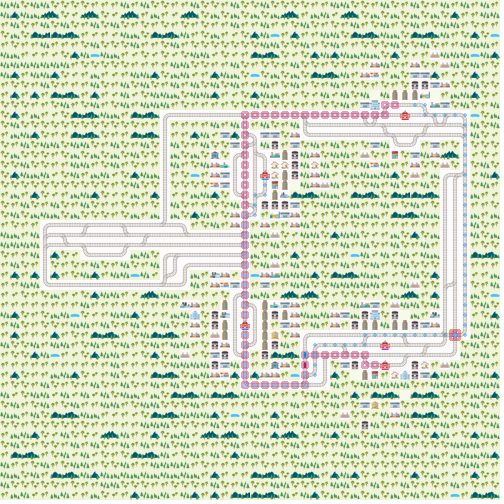

In [210]:
import PIL

def render_env(env):
    env_renderer = RenderTool(env, gl="PILSVG")
    
    for i in range(7):
        
        if i == 1:
            env.dev_obs_dict[i] = [(10, 39), (10, 38), (11, 38), (11, 37), (11, 36), (11, 35), (11, 34), (11, 33), (11, 32), (11, 31), (11, 30), (11, 29), (11, 28), (11, 27), (11, 26), (11, 25), (11, 24), (12, 24), (13, 24), (14, 24), (15, 24), (16, 24), (17, 24), (18, 24), (19, 24), (20, 24), (21, 24), (22, 24), (23, 24), (24, 24), (25, 24), (26, 24), (27, 24), (28, 24), (29, 24), (30, 24), (31, 24), (32, 24), (33, 24), (34, 24), (35, 24), (36, 24), (37, 24), (38, 24), (38, 25), (38, 26), (38, 27), (38, 28), (38, 29), (38, 30), (37, 30), (36, 30), (35, 30), (35, 31), (35, 32), (35, 33), (35, 34), (35, 35), (35, 36), (36, 36), (36, 37), (36, 38)]
        
        elif i == 6:
            env.dev_obs_dict[i] = [(10, 41), (10, 42), (11, 42), (11, 43), (11, 44), (11, 45), (11, 46), (12, 46), (13, 46), (14, 46), (15, 46), (16, 46), (17, 46), (18, 46), (19, 46), (20, 46), (21, 46), (22, 46), (23, 46), (24, 46), (25, 46), (26, 46), (27, 46), (28, 46), (29, 46), (30, 46), (31, 46), (32, 46), (33, 46), (33, 46), (33, 46), (33, 45), (33, 44), (33, 43), (33, 42), (33, 41), (33, 40), (33, 39), (33, 38), (33, 37), (33, 36), (34, 36), (34, 35), (34, 34), (34, 33), (34, 32), (34, 31), (35, 31), (36, 31), (36, 31), (37, 31), (37, 30), (38, 30), (38, 29), (38, 28), (38, 27), (38, 26), (38, 25), (38, 24), (37, 24), (36, 24), (35, 24), (34, 24), (33, 24), (32, 24), (31, 24), (30, 24), (29, 24), (28, 24), (27, 24), (26, 24), (25, 24), (24, 24), (23, 24), (22, 24), (21, 24), (21, 25), (20, 25), (19, 25), (19, 26), (18, 26), (17, 26)]
        
        else:
            env.dev_obs_dict[i] = [(33, 45)]
    
    
    
    env_renderer.render_env(show=True, frames=False, show_observations=True, show_predictions=False)

    image = env_renderer.get_image()
    pil_image = PIL.Image.fromarray(image)
    display(pil_image)
    
    
render_env(env)

In [203]:
z = 30

lst = [(10, 41), (10, 42), (11, 42), (11, 43), (11, 44), (11, 45), (11, 46), (12, 46), (13, 46), (14, 46), (15, 46), (16, 46), (17, 46), (18, 46), (19, 46), (20, 46), (21, 46), (22, 46), (23, 46), (24, 46), (25, 46), (26, 46), (27, 46), (28, 46), (29, 46), (30, 46), (31, 46), (32, 46), (33, 46), (33, 45), (33, 45), (33, 45), (33, 44), (33, 43), (33, 42), (33, 41), (33, 40), (33, 39), (33, 38), (33, 37), (33, 36), (34, 36), (34, 35), (34, 34), (34, 33), (34, 32), (34, 31), (35, 31), (36, 31), (37, 31), (37, 31), (37, 30), (38, 30), (38, 29), (38, 28), (38, 27), (38, 26), (38, 25), (38, 24), (37, 24), (36, 24), (35, 24), (34, 24), (33, 24), (32, 24), (31, 24), (30, 24), (29, 24), (28, 24), (27, 24), (26, 24), (25, 24), (24, 24), (23, 24), (22, 24), (21, 24), (21, 25), (20, 25), (19, 25), (19, 26), (18, 26), (17, 26)]
print(lst[z])

l = [2, 3, 1, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 2, 2, 2, 2, 1, 2, 2, 4, 3, 1, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 2, 3, 1, 2]
print(l[z])     

(33, 45)
4
